In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sys
sys.path.append("..")

from cardinality_estimation.featurizer import Featurizer
from query_representation.query import load_qrep
from cardinality_estimation.dataset import *
from torch.utils import data

import glob
import random
import os
import json
import time
import matplotlib.pyplot as plt

# Setup file paths / Download query data

In [2]:
import errno
def make_dir(directory):
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

In [63]:
TRAINDIR = os.path.join(os.path.join("..", "queries"), "imdb")
TESTDIR = os.path.join(os.path.join("..", "queries"), "imdb-unique-plans")
RESULTDIR = os.path.join("..", "results")
make_dir(RESULTDIR)

# Query loading helper functions

In [64]:
def load_qdata(fns):
    qreps = []
    for qfn in fns:
        qrep = load_qrep(qfn)
        # TODO: can do checks like no queries with zero cardinalities etc.
        qreps.append(qrep)
        template_name = os.path.basename(os.path.dirname(qfn))
        qrep["name"] = os.path.basename(qfn)
        qrep["template_name"] = template_name
    return qreps

def get_query_fns(basedir, template_fraction=1.0, sel_templates=None):
    fns = []
    tmpnames = list(glob.glob(os.path.join(basedir, "*")))
    assert template_fraction <= 1.0
    
    for qi,qdir in enumerate(tmpnames):
        if os.path.isfile(qdir):
            continue
        template_name = os.path.basename(qdir)
        if sel_templates is not None and template_name not in sel_templates:
            continue
        
        # let's first select all the qfns we are going to load
        qfns = list(glob.glob(os.path.join(qdir, "*.pkl")))
        qfns.sort()
        num_samples = max(int(len(qfns)*template_fraction), 1)
        random.seed(1234)
        qfns = random.sample(qfns, num_samples)
        fns += qfns
    return fns

# Evaluation helper functions

# Load queries

In [65]:
# set template_fraction <= 1.0 to test quickly w/ smaller datasets
# train_qfns = get_query_fns(TRAINDIR, template_fraction = 0.001)
# val_qfns = get_query_fns(VALDIR, template_fraction = 1.0)
# test_qfns = get_query_fns(TESTDIR, template_fraction = 1.0)

#qfns = get_query_fns(TRAINDIR, template_fraction = 1.0, sel_templates=None)

qfns = get_query_fns(TRAINDIR, template_fraction = 1.0, sel_templates="1a")
qdata = load_qdata(qfns)

In [69]:
from collections import defaultdict
import numpy

subplan_data = defaultdict(list)

rowkeys = set()
for qi, qrep in enumerate(qdata):
    for node in qrep["subset_graph"].nodes():
        rowkeys.add(node)
rowkeys = list(rowkeys)
rowkeys.sort()
rowidxs = {rk:ri for ri,rk in enumerate(rowkeys)}
#print(rowidxs)
mat = np.zeros((len(rowidxs), len(qdata)))

for qi, qrep in enumerate(qdata):
    for node in qrep["subset_graph"].nodes():
        truec = qrep["subset_graph"].nodes()[node]["cardinality"]["actual"]
        mat[rowidxs[node], qi] = truec
        
mat = mat.T

In [70]:
mat.shape

(3000, 107)

In [71]:
P, S, Q = np.linalg.svd(mat, full_matrices=False)
print(S.shape)

(107,)


In [72]:
S.round(2)

array([2.65174343e+09, 8.83634782e+08, 5.53066760e+08, 4.83999874e+08,
       4.39969921e+08, 3.75377451e+08, 3.60130403e+08, 1.62733858e+08,
       1.51016121e+08, 1.46137262e+08, 1.17527934e+08, 1.06720927e+08,
       1.02351064e+08, 9.33266596e+07, 8.05052233e+07, 7.09017101e+07,
       6.60912391e+07, 5.98012537e+07, 5.26473223e+07, 4.39207286e+07,
       3.38708239e+07, 2.91934710e+07, 2.82427143e+07, 2.69020724e+07,
       2.38167673e+07, 2.22973001e+07, 2.12865880e+07, 2.04507681e+07,
       1.87017794e+07, 1.75690582e+07, 1.62084493e+07, 1.61203257e+07,
       1.37156107e+07, 1.24735301e+07, 1.09821580e+07, 9.46514289e+06,
       8.32117465e+06, 7.63875979e+06, 7.50236841e+06, 6.99401790e+06,
       6.84023515e+06, 6.32274279e+06, 6.26319038e+06, 5.77718529e+06,
       4.21104092e+06, 4.01064510e+06, 3.69278975e+06, 3.47716622e+06,
       3.29553722e+06, 2.56320693e+06, 2.34489650e+06, 2.13196374e+06,
       2.02041098e+06, 1.90157759e+06, 1.63836278e+06, 1.56515948e+06,
      

In [73]:
np.percentile(S, 90)

111043729.6305563

In [75]:
# rank = np.sum(S > 1e10)
# rank

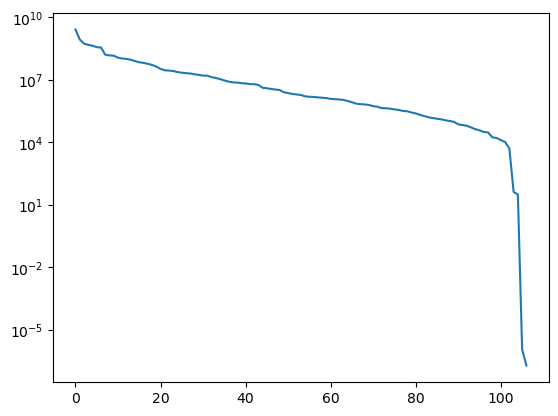

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

#sns.lineplot(np.log(S))
sns.lineplot(S)
plt.yscale("log")

In [77]:
cds = np.cumsum(S) / np.sum(S)
r90 = np.min(np.where(cds > 0.90))
r90

14

In [78]:
def omega_approx(beta):
    """Return an approximate omega value for given beta. Equation (5) from Gavish 2014."""
    return 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43

def svht(X, sigma=None, sv=None):
    """Return the optimal singular value hard threshold (SVHT) value.
    `X` is any m-by-n matrix. `sigma` is the standard deviation of the 
    noise, if known. Optionally supply the vector of singular values `sv`
    for the matrix (only necessary when `sigma` is unknown). If `sigma`
    is unknown and `sv` is not supplied, then the method automatically
    computes the singular values."""

    try:
        m,n = sorted(X.shape) # ensures m <= n
    except:
        raise ValueError('invalid input matrix')
    beta = m / n # ratio between 0 and 1
    if sigma is None: # sigma unknown
        if sv is None:
            sv = svdvals(X)
        sv = np.squeeze(sv)
        if sv.ndim != 1:
            raise ValueError('vector of singular values must be 1-dimensional')
        return np.median(sv) * omega_approx(beta)
    else: # sigma known
        return lambda_star(beta) * np.sqrt(n) * sigma

# find tau star hat when sigma is unknown
# tau = svht(D, sv=sv)

# # find tau star when sigma is known
# tau = svht(D, sigma=0.5)

In [79]:
tau = svht(mat, sv=S)

In [80]:
tau

2840443.9417044045

In [81]:
rank = np.sum(S > tau)
rank

49